In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import colormaps as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from windspharm.xarray import VectorWind
from windspharm.tools import prep_data, recover_data, order_latdim
import metpy.calc as mpcalc
from metpy.units import units
import pickle

from PIL import Image # pip install Pillow
import sys
import glob
from PIL import ImageOps
import numpy as np
# Trim all png images with white background in a folder
# Usage "python PNGWhiteTrim.py ../someFolder padding"
def crop(path, in_padding=1,**kwargs):
    Image.MAX_IMAGE_PIXELS = None
    
    try:
        padding = int(in_padding)
        padding = np.asarray([-1*padding, -1*padding, padding, padding])
    except :
        print("Usage: python PNGWhiteTrim.py ../someFolder padding")
        sys.exit(1)
    
    filePaths = glob.glob(path) #search for all png images in the folder
    
    if len(filePaths) == 0:
        print("No files detected!")
    
    for filePath in filePaths:
        image=Image.open(filePath)
        image.load()
        imageSize = image.size
    
        # remove alpha channel
        invert_im = image.convert("RGB")
    
        # invert image (so that white is 0)
        invert_im = ImageOps.invert(invert_im)
        imageBox = invert_im.getbbox()
        imageBox = tuple(np.asarray(imageBox)+padding)
    
        cropped=image.crop(imageBox)
        print(filePath, "Size:", imageSize, "New Size:", imageBox)
        cropped.save(filePath)

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-bdw-0034
--------------------------------------------------------------------------


In [3]:
#home_path='/home/565/mb0427/gdata-gb02/WeatherRegimes/weather-maps-australia/'
#regfile=home_path+'cluster_data/clusters_030_850_1952-01_2023-12_12.nc'
#regimes=xr.open_dataset(regfile)#.clusterID#sel(clusterID==1)
#clusterIDs=regimes.clusterID
#regimes=regimes.clusterSeries.sel(time=slice(datetime(1960,1,1),datetime(2024,1,1)))

In [4]:
with open(home_path+'SWT_fields/SWT_WR_definitions.pkl', 'rb') as fp:
    SWTs = pickle.load(fp)

l1 = [SWTs[i]["WR"] for i in SWTs]
WRs = []
s = set()
for i in l1:
   if not i in s:
       WRs.append(i)
       s.add(i)

regime_clusters={}
for WR in WRs:
    regime_clusters[WR]=[]
    for i in SWTs:
        if SWTs[i]["WR"]==WR:
            regime_clusters[WR].append(i)

In [12]:
import pandas as pd

inpath='/home/565/mb0427/gdata-gb02/WeatherRegimes/'
dsMSL=[]
dsPV315=[]
dsPV330=[]
dsU850=[]
dsV850=[]
dsU=[]
dsV=[]
dsTCWV=[]
for i,code in enumerate(SWTs):
    SWT=SWTs[code]
    WR=SWT["WR"]
    SWTcode=SWT["SWT"]
    #innewname = fr"${WR}_{{{SWTcode}}}$"
    innewname = WR+"-"+SWTcode #fr"${WR}-{SWTcode}$"
    inname = "Regime"+str(code)
    outname = "Cluster"+str(code)
    
    inval='msl'
    t=0
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsMSL.append(xr.open_dataset(infile)/100)

    inval='pv_315K'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsPV315.append(xr.open_dataset(infile))

    inval='pv_330K'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsPV330.append(xr.open_dataset(infile))

    inval='u_850hPa'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsU850.append(xr.open_dataset(infile))

    inval='v_850hPa'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsV850.append(xr.open_dataset(infile))

    inval='u_300hPa'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsU.append(xr.open_dataset(infile))

    inval='v_300hPa'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsV.append(xr.open_dataset(infile))

    inval='tcwv'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsTCWV.append(xr.open_dataset(infile))

dsMSL=xr.concat(dsMSL,pd.Index(list(SWTs.keys()), name="clusterID"),coords="minimal",compat='override')
dsPV315=xr.concat(dsPV315,pd.Index(list(SWTs.keys()), name="clusterID"),coords="minimal",compat='override')
dsPV330=xr.concat(dsPV330,pd.Index(list(SWTs.keys()), name="clusterID"),coords="minimal",compat='override')
dsU850=xr.concat(dsU850,pd.Index(list(SWTs.keys()), name="clusterID"),coords="minimal",compat='override')
dsV850=xr.concat(dsV850,pd.Index(list(SWTs.keys()), name="clusterID"),coords="minimal",compat='override')
dsU=xr.concat(dsU,pd.Index(list(SWTs.keys()), name="clusterID"),coords="minimal",compat='override')
dsV=xr.concat(dsV,pd.Index(list(SWTs.keys()), name="clusterID"),coords="minimal",compat='override')
dsTCWV=xr.concat(dsTCWV,pd.Index(list(SWTs.keys()), name="clusterID"),coords="minimal",compat='override')

dsMSL=dsMSL.drop_vars('time')
dsPV315=dsPV315.drop_vars(['time','level']).rename({'pv':'pv315'})
dsPV330=dsPV330.drop_vars(['time','level']).rename({'pv':'pv330'})
dsU850=dsU850.drop_vars(['time','level']).rename({'u':'u850'})
dsV850=dsV850.drop_vars(['time','level']).rename({'v':'v850'})
dsU=dsU.drop_vars(['time','level']).rename({'u':'u300'})
dsV=dsV.drop_vars(['time','level']).rename({'v':'v300'})
dsTCWV=dsTCWV.drop_vars('time')

outfile=inpath+'Composite_ERA5_SWT_composites.nc'
xr.merge([dsMSL,dsPV315,dsPV330,dsU850,dsV850,dsU,dsV,dsTCWV]).to_netcdf(outfile)


In [10]:
outfile 

'/home/565/mb0427/gdata-gb02/WeatherRegimes/Composite_ERA5_SWT_composites.nc'

/home/565/mb0427/gdata-gb02/WeatherRegimes/weather-maps-australia/plots/Synoptics_SWT_ERA5.jpg Size: (6600, 4800) New Size: (374, 269, 6458, 4291)


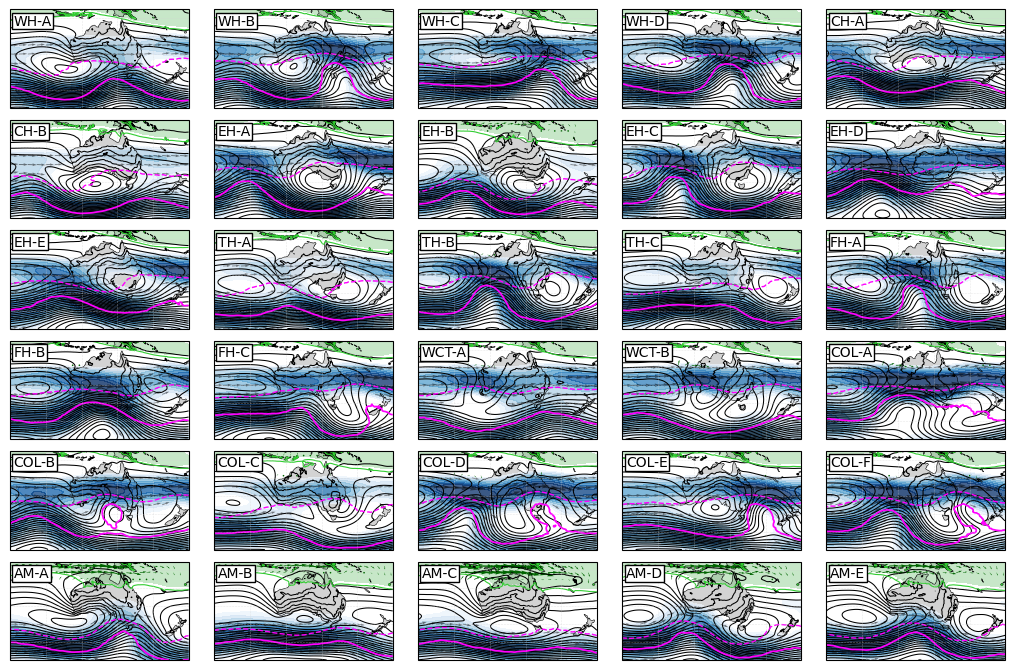

In [4]:
plot_extent=[80,180,-60,-5]
figsize=(11,8)
fig, axs = plt.subplots(6, 5, figsize=figsize, subplot_kw=dict(projection=ccrs.PlateCarree())) 
ax_list=axs.reshape(-1)

inpath='/home/565/mb0427/gdata-gb02/WeatherRegimes/'
for i,code in enumerate(SWTs):
    SWT=SWTs[code]
    WR=SWT["WR"]
    SWTcode=SWT["SWT"]
    #innewname = fr"${WR}_{{{SWTcode}}}$"
    innewname = WR+"-"+SWTcode #fr"${WR}-{SWTcode}$"
    inname = "Regime"+str(code)
    inval='msl'
    t=0
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsMSL=xr.open_dataset(infile)/100

    inval='pv_315K'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsPV315=xr.open_dataset(infile)

    inval='pv_330K'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsPV330=xr.open_dataset(infile)

    inval='u_850hPa'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsU850=xr.open_dataset(infile)

    inval='v_850hPa'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsV850=xr.open_dataset(infile)

    inval='u_300hPa'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsU=xr.open_dataset(infile)

    inval='v_300hPa'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsV=xr.open_dataset(infile)

    inval='tcwv'
    infile=inpath+'Composite_ERA5_'+inname+'_'+inval+'_d'+str(t)+'.nc'
    dsTCWV=xr.open_dataset(infile)
    
    spd300=mpcalc.wind_speed(dsU.u * units('m/s'), dsV.v  * units('m/s')).metpy.dequantify()
    ujet300=dsU.u.where(spd300>40*0.514444)
    vjet300=dsV.v.where(spd300>40*0.514444)
    jet300=spd300.where(spd300>35*0.514444)

    uW850=dsU850.u.where(dsU850.u>0).sel(latitude=slice(0,-20))
    vW850=dsV850.v.where(dsU850.u>0).sel(latitude=slice(0,-20))
    
    ax=ax_list[i]
    ax.set_extent(plot_extent,crs=ccrs.PlateCarree())

    ax.add_feature(LAND,facecolor='lightgrey')
    ax.coastlines(linewidths=0.4)
    
    plot_levels = list(range(900,1060,2))
    c=ax.contour(dsMSL.longitude,dsMSL.latitude,dsMSL.msl,
                     levels=plot_levels,colors='black',linewidths=0.75,linestyles='-',
                     transform=ccrs.PlateCarree())
    
    plot_levels = range(35,80,5)
    cf=ax.contourf(jet300.longitude,jet300.latitude,jet300*1.94384,
                   levels=plot_levels,cmap='Blues',extend='max',
                   transform=ccrs.PlateCarree(),alpha=0.75)

    plot_levels = range(48,1000,500)
    cf=ax.contourf(dsTCWV.longitude,dsTCWV.latitude,dsTCWV.tcwv,
                   levels=plot_levels,cmap='Greens',extend='max',
                   transform=ccrs.PlateCarree(),alpha=0.4)
    
    c=ax.contour(dsTCWV.longitude,dsTCWV.latitude,dsTCWV.tcwv,
                     levels=[45],colors='limegreen',linewidths=0.8,linestyles='-',
                     transform=ccrs.PlateCarree())
    
    nvec=15
    q=ax.quiver(uW850.longitude[::nvec],uW850.latitude[::nvec], 
                 uW850[::nvec,::nvec], vW850[::nvec,::nvec],
                  scale=1,scale_units='xy',width=0.01,minshaft=2,color='darkgreen',# minlength=1,
                  transform=ccrs.PlateCarree())
    nvec=20
    q=ax.quiver(jet300.longitude[::nvec],jet300.latitude[::nvec], 
                 ujet300[::nvec,::nvec], vjet300[::nvec,::nvec],
                  scale=5,scale_units='xy',width=0.01,minshaft=2,# minlength=1,
                  transform=ccrs.PlateCarree(), alpha=0.5)

    c=ax.contour(dsPV330.longitude,dsPV330.latitude,dsPV330.pv*1e6,
                     levels=[-2],colors='magenta',linewidths=1.0,linestyles='--',
                     transform=ccrs.PlateCarree())
    c=ax.contour(dsPV315.longitude,dsPV315.latitude,dsPV315.pv*1e6,
                     levels=[-2],colors='magenta',linewidths=1.25,linestyles='-',
                     transform=ccrs.PlateCarree())

    label=ax.text(82,-11.5,innewname,ha='left',va='center',fontsize=10,
                          bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='black'))
    
    gl = ax.gridlines(transform=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='lightgrey', alpha=0.5, linestyle='--')
    #xlocators=list(np.arange(-180,190,10))
    #gl.xlocator = mticker.FixedLocator(xlocators)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    gl.left_labels = False
    
    #ax.set_title(innewname +' (Cluster '+str(code)+')', fontsize=10)

fig.tight_layout(pad=0.4)
fig.subplots_adjust(left=0.065, right=0.97, top=0.94, bottom=0.11, wspace=0.14)

#fig.suptitle('Synoptics for Regimes\n'+
#             'MSLP (black contours), 300hPa jet (blue shading and black quivers), moist margin (green shading)\n'+
#             '850hPa tropical westerlies (green quivers), 315K -2 PVU (solid magenta) and 330K -2 PVU (dashed magenta)',
#             fontsize=10)

#ax_pos=[0.4,0.1,0.3,0.01]
#cbar_ax = fig.add_axes(ax_pos)
#cb=fig.colorbar(cf,orientation="horizontal", cax=cbar_ax)
#cb.ax.tick_params(labelsize=8)
#cb.set_label('Wind Speed [kt]', rotation=0, fontsize=8)

outfile=home_path+'plots/Synoptics_SWT_ERA5.jpg'
plt.savefig(outfile, dpi=600)
crop(outfile,in_padding=50)
plt.show()